In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, # split data into train and test sets
    GridSearchCV # grid search for neural network parameter optimisation
)
from sklearn import (
    metrics,
    #preprocessing
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor # decision tree regressor
from sklearn.ensemble import (
    RandomForestRegressor, # random forest regressor
    GradientBoostingRegressor # gradient boosting regressor
)
from sklearn.neural_network import MLPRegressor # neural network regressor
from sklearn import tree

%matplotlib inline

# Multi-variable regression using Machine Learning

Load transistor DC Operating Point data obtained from simulations in Cadence-Virtuoso ADE L environment.

In [2]:
data_file = "/Users/dasdias/Documents/PhD-NOVA/Circuits/ResidueAmplifier_Gain8_28nmTSMC/goverpy/src/data/luts/ncell.csv"
nmos_df = pd.read_csv(data_file)
nmos_df = nmos_df.reset_index()
print(f"Data Shape: {nmos_df.shape}")
# shuffle the dataframe
nmos_df = nmos_df.sample(frac=1).reset_index(drop=True)
nmos_df.head(10)

Data Shape: (4550, 24)


,index,Unnamed: 0,vdsat,self_gain,region,ron,id,gmoverid,gmbs,gm,...,cdb,cgd,cgb,vsb,w,l,vds,vgs,vearly,cds
0,225,225,0.1037,8.9390,0.0,135000000.0,6.941000e-09,26.6000,9.663000e-09,1.774000e-07,...,5.794000e-16,3.246000e-16,9.960000e-17,0.6,0.000002,3.000000e-08,0.9,0.00,NaN,NaN
1,1306,1306,0.1056,0.0000,3.0,inf,-5.947000e-13,0.0000,0.000000e+00,0.000000e+00,...,9.547000e-16,4.930000e-16,2.277000e-16,0.0,0.000002,6.000000e-08,0.0,0.30,NaN,NaN
2,3907,3907,0.1042,0.0000,3.0,NaN,-5.243000e-13,0.0000,0.000000e+00,0.000000e+00,...,8.515000e-16,4.933000e-16,8.349000e-17,0.2,0.000002,3.000000e-08,0.0,0.35,0.0000,-4.533000e-17
3,2602,2602,NaN,NaN,0.0,NaN,9.501000e-13,0.0000,0.000000e+00,0.000000e+00,...,8.029000e-16,3.708000e-16,NaN,0.3,0.000002,6.000000e-08,0.0,0.10,NaN,NaN
4,696,696,0.3786,0.1398,1.0,NaN,5.312000e-04,1.2450,6.201000e-05,6.612000e-04,...,7.803000e-16,1.456000e-15,NaN,0.6,0.000002,6.000000e-08,0.1,1.05,NaN,NaN
5,424,424,0.4819,0.4212,1.0,NaN,1.899000e-03,0.8593,1.088000e-04,1.632000e-03,...,8.143000e-16,5.709000e-16,1.235000e-17,0.1,0.000002,3.000000e-08,0.3,1.20,0.4902,-4.153000e-16
6,4545,4545,0.4073,8.9170,2.0,546.8,2.195000e-03,1.7930,1.714000e-04,3.935000e-03,...,5.944000e-16,3.518000e-16,1.820000e-17,0.5,0.000002,3.000000e-08,1.2,1.00,NaN,NaN
7,813,813,0.1954,16.4700,2.0,NaN,3.045000e-04,7.3410,1.846000e-04,2.235000e-03,...,6.630000e-16,3.731000e-16,NaN,0.6,0.000002,6.000000e-08,0.6,0.65,NaN,NaN
8,3932,3932,0.1045,4.1810,3.0,NaN,1.100000e-05,21.3500,1.582000e-05,2.349000e-04,...,8.081000e-16,3.760000e-16,9.036000e-17,0.2,0.000002,3.000000e-08,0.1,0.35,0.1958,-6.441000e-17
9,874,874,0.4810,6.9390,2.0,NaN,2.022000e-03,1.4950,1.934000e-04,3.024000e-03,...,6.571000e-16,4.198000e-16,NaN,0.6,0.000002,6.000000e-08,0.8,1.20,NaN,NaN


As it is possible to observe, the data is not normalized, and therefore, normalization must occur. However, before normalization occurs, the missing values of the table (inifinities and NaNs) must be substituted by suitable values in order to enable the training of ML algorithms to perform regression. In this case, infinities will be substituted by -1 whilst NaN will be replaced by 0 - because infinities must be preserved.

In [3]:
nmos_df.describe()

,index,Unnamed: 0,vdsat,self_gain,region,ron,id,gmoverid,gmbs,gm,...,cdb,cgd,cgb,vsb,w,l,vds,vgs,vearly,cds
count,4550.000000,4550.000000,4225.000000,4225.000000,4550.000000,1300.00,4.550000e+03,4550.000000,4.550000e+03,4550.000000,...,3.575000e+03,4.550000e+03,3.250000e+03,4550.000000,4.550000e+03,4.550000e+03,4550.000000,4550.000000,2275.000000,9.750000e+02
mean,2274.500000,2274.500000,0.226832,9.881028,1.829670,inf,6.003271e-04,11.556755,1.054061e-04,0.001555,...,7.138037e-16,4.663620e-16,8.206046e-17,0.300000,2.300000e-06,4.500000e-08,0.600000,0.600000,1.665718,-2.604245e-16
std,1313.616192,1313.616192,0.128108,6.720355,0.874015,NaN,7.460737e-04,11.433672,9.294305e-05,0.001415,...,9.649096e-17,2.707209e-16,6.877306e-17,0.200022,9.699593e-20,1.500165e-08,0.374207,0.360595,1.834519,1.933571e-16
min,0.000000,0.000000,0.101400,0.000000,0.000000,128.80,-3.346000e-09,0.000000,0.000000e+00,0.000000,...,5.520000e-16,3.203000e-16,8.011000e-18,0.000000,2.300000e-06,3.000000e-08,0.000000,0.000000,0.000000,-4.956000e-16
25%,1137.250000,1137.250000,0.105400,4.255000,1.000000,463.25,3.227500e-07,1.916500,7.393000e-07,0.000009,...,6.416000e-16,3.415000e-16,2.710000e-17,0.100000,2.300000e-06,3.000000e-08,0.300000,0.300000,0.395000,-4.538500e-16
50%,2274.500000,2274.500000,0.182400,9.630000,2.000000,2051.00,2.222500e-04,5.548000,1.027500e-04,0.001352,...,6.951000e-16,3.678000e-16,6.062000e-17,0.300000,2.300000e-06,4.500000e-08,0.600000,0.600000,0.769900,-2.938000e-16
75%,3411.750000,3411.750000,0.331300,17.240000,2.000000,795050.00,1.075000e-03,24.707500,1.881000e-04,0.002981,...,7.703000e-16,4.092250e-16,1.078000e-16,0.500000,2.300000e-06,6.000000e-08,0.900000,0.900000,2.431000,-1.683000e-17
max,4549.000000,4549.000000,0.530800,20.330000,3.000000,inf,3.055000e-03,31.390000,2.763000e-04,0.003962,...,1.055000e-15,1.617000e-15,2.934000e-16,0.600000,2.300000e-06,6.000000e-08,1.200000,1.200000,9.333000,-3.719000e-22


In [4]:
nmos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       4550 non-null   int64  
 1   Unnamed: 0  4550 non-null   int64  
 2   vdsat       4225 non-null   float64
 3   self_gain   4225 non-null   float64
 4   region      4550 non-null   float64
 5   ron         1300 non-null   float64
 6   id          4550 non-null   float64
 7   gmoverid    4550 non-null   float64
 8   gmbs        4550 non-null   float64
 9   gm          4550 non-null   float64
 10  gds         4550 non-null   float64
 11  ft          4550 non-null   float64
 12  csb         4550 non-null   float64
 13  cgs         4550 non-null   float64
 14  cdb         3575 non-null   float64
 15  cgd         4550 non-null   float64
 16  cgb         3250 non-null   float64
 17  vsb         4550 non-null   float64
 18  w           4550 non-null   float64
 19  l           4550 non-null  

In [5]:
# replace infinity or NaN values for 0, in order to avoid errors
nmos_df.fillna(0, inplace=True)
nmos_df.replace(np.nan, 0, inplace=True)
nmos_df.replace(np.inf, 0, inplace=True)
nmos_df.replace(-np.inf, 0, inplace=True)
nmos_df.drop(columns=["Unnamed: 0"], inplace=True)
nmos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   index      4550 non-null   int64  
 1   vdsat      4550 non-null   float64
 2   self_gain  4550 non-null   float64
 3   region     4550 non-null   float64
 4   ron        4550 non-null   float64
 5   id         4550 non-null   float64
 6   gmoverid   4550 non-null   float64
 7   gmbs       4550 non-null   float64
 8   gm         4550 non-null   float64
 9   gds        4550 non-null   float64
 10  ft         4550 non-null   float64
 11  csb        4550 non-null   float64
 12  cgs        4550 non-null   float64
 13  cdb        4550 non-null   float64
 14  cgd        4550 non-null   float64
 15  cgb        4550 non-null   float64
 16  vsb        4550 non-null   float64
 17  w          4550 non-null   float64
 18  l          4550 non-null   float64
 19  vds        4550 non-null   float64
 20  vgs     

After performing data normalization, the dataset must be splitted into training and testing datasets.
When sizing a CMOS transistor, the degrees of freedom for the sizing operation are the VDS, the VSB, the L, the Gm/Id and the Drain Current Id parameters, and therefore, these are the parameters that are ought to be used as input parameters for our model.

In [6]:
x_columns = ["gmoverid", "vds", "vsb", "l"]
Y = nmos_df.drop(columns=x_columns).drop(columns=["index"])
X = nmos_df[x_columns]
y_scaler = MinMaxScaler()
x_scaler = MinMaxScaler()
y_scaler.fit(Y)
x_scaler.fit(X)
Y_norm = y_scaler.transform(Y)
X_norm = x_scaler.transform(X)
Y_norm = pd.DataFrame(Y_norm, columns=Y.columns)
X_norm = pd.DataFrame(X_norm, columns=X.columns)
X_norm.head(5)

,gmoverid,vds,vsb,l
0,0.847404,0.750000,1.000000,0.0
1,0.000000,0.000000,0.000000,1.0
2,0.000000,0.000000,0.333333,0.0
3,0.000000,0.000000,0.500000,1.0
4,0.039662,0.083333,1.000000,1.0


In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, Y_norm, test_size=0.12, random_state=1234)
print("X Testing Shape: ", X_test.shape)
print("Y Training Shape: ", Y_train.shape)
Y_test.head(5)

X Testing Shape:  (546, 4)
Y Training Shape:  (4004, 18)


,vdsat,self_gain,region,ron,id,gmbs,gm,gds,ft,csb,cgs,cdb,cgd,cgb,w,vgs,vearly,cds
1070,0.850038,0.268519,0.666667,0.000000e+00,0.800000,0.695621,0.909642,0.079380,0.858781,0.633915,0.479417,0.662085,0.046503,0.057260,0.0,0.916667,0.396657,0.008273
1627,0.332329,0.442794,0.666667,6.350114e-07,0.147399,0.591748,0.736244,0.038956,0.794685,0.247410,0.365586,0.647299,0.039716,0.133879,0.0,0.500000,0.000000,1.000000
3115,0.549736,0.121692,0.666667,0.000000e+00,0.262063,0.802389,0.607774,0.117049,0.343147,0.628292,0.925421,0.000000,0.219480,0.177403,0.0,0.708333,0.088128,1.000000
2271,0.208930,0.461043,0.666667,4.415332e-06,0.012724,0.146507,0.173826,0.008834,0.264461,0.193252,0.131495,0.666730,0.039022,0.255521,0.0,0.333333,0.000000,1.000000
369,0.000000,0.000000,0.666667,0.000000e+00,0.261605,0.931958,0.774609,0.025875,0.470558,0.490086,0.928365,0.670995,0.047582,0.000000,0.0,0.666667,0.000000,1.000000


## 1- Using Artificial Neural Networks (ANN) to perform Multi-variable Regression

### 1.1-Multi-Layer Perceptron NN Hyperparameters Optimisation

In [8]:
# perform hyperparameter optimization with GridSearchCV
parameters = {
    "hidden_layer_sizes": [(size,) for size in np.arange(16, 128, 16)], 
    "activation": ["identity", "logistic", "tanh", "relu"], 
    "solver": ["lbfgs", "sgd", "adam"], 
    "alpha": np.arange(0.01, 0.31, 0.1),
}

In [9]:
gridCVMLP = GridSearchCV(MLPRegressor(max_iter=10000), parameters, cv=6, n_jobs = -1)        # estimator = an instance of DecisionTreeClassifier.
gridCVMLP.fit(X_train, Y_train)
best_hidden_layer_size = gridCVMLP.best_params_['hidden_layer_sizes']
best_activation_fun = gridCVMLP.best_params_['activation']
best_solver = gridCVMLP.best_params_['solver']
best_alpha = gridCVMLP.best_params_['alpha'] # gradient descent momentum parameter
print( f"Best Hidden Layer Size: {best_hidden_layer_size}")
print( f"Best Activation Function: {best_activation_fun}")
print( f"Best Solver: {best_solver}")
print( f"Best Alpha: {best_alpha}")

/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the nu

Best Hidden Layer Size: (112,)
Best Activation Function: relu
Best Solver: lbfgs
Best Alpha: 0.01


### 1.2- Multi-Layer Perceptron Regressor training and testing

In [10]:
MLPR_best = gridCVMLP.best_estimator_
MLPR_best.fit(X_train, Y_train)
Y_pred = MLPR_best.predict(X_test)
print( "Tree best RMSE : " + str(np.round(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred, squared=True)),5)))

Tree best RMSE : 0.08229


In [11]:
# Testing the Bayesian Decision Tree Regressor
x_evaluating = X_test.iloc[0:1]
x_evaluating

,gmoverid,vds,vsb,l
1070,0.046958,0.666667,0.166667,0.0


In [12]:
y_evaluation = MLPR_best.predict(x_evaluating)
y_evaluation

array([[8.36778675e-01, 2.34830154e-01, 6.47520304e-01, 3.74169270e-03,
        7.77137848e-01, 6.66559877e-01, 8.91392135e-01, 9.41355570e-02,
        8.43821975e-01, 6.45808345e-01, 4.81414406e-01, 6.74781521e-01,
        4.27246871e-02, 5.74275056e-02, 4.10047627e-04, 9.08957338e-01,
        3.62739316e-01, 1.35073196e-02]])

In [13]:
# denormalising the prediction
y_evaluation = y_scaler.inverse_transform(y_evaluation)
predicted = pd.DataFrame(y_evaluation, columns=Y.columns, index=["Predicted"])
real = pd.DataFrame(y_scaler.inverse_transform(Y_test.iloc[0:1]), columns=Y.columns, index=["Real"])
# Comparing the predicted values with the real values
pd.concat([predicted, real], axis=0).T 

,Predicted,Real
vdsat,4.441621e-01,4.512000e-01
self_gain,4.774097e+00,5.459000e+00
region,1.942561e+00,2.000000e+00
ron,6.540479e+06,0.000000e+00
id,2.374155e-03,2.444000e-03
gmbs,1.841705e-04,1.922000e-04
gm,3.531696e-03,3.604000e-03
gds,7.829255e-04,6.602000e-04
ft,3.238589e+11,3.296000e+11
csb,9.353186e-16,9.313000e-16


## 2- Using Bayesian Decision Tree to perform Multi-Variable Regression

The hyperparameters of the Bayesian Tree need to be optimized in order perform the best regression possible of the data set, and as such, an hyperparameter optimizing algorithm such as GridSeachCV is often used.

### 2.1- Bayesian Tree Hyperparameters Optimisation

In [14]:
depth_grid = np.arange(1,21) # the depth of the tree will be between 1 and 20 branching rows
min_samples_leaf_grid = np.arange(2,31) # the minimum number of samples in each leaf will be between 10 and 30
max_leaf_nodes_grid = np.arange(2,41) # the maximum number of leaf nodes will be between 2 and 20
parameters = {'max_depth':depth_grid, 'min_samples_leaf':min_samples_leaf_grid, 'max_leaf_nodes':max_leaf_nodes_grid}

In [15]:
gridCV = GridSearchCV(DecisionTreeRegressor(), parameters, cv=6, n_jobs = -1)        # estimator = an instance of DecisionTreeClassifier.
gridCV.fit(X_train, Y_train)
best_depth = gridCV.best_params_['max_depth']
best_min_samples_leaf = gridCV.best_params_['min_samples_leaf']
best_max_leaf_nodes = gridCV.best_params_['max_leaf_nodes']
print("Tree best depth : " + str(best_depth))
print("Tree best min_samples_leaf : " + str(best_min_samples_leaf))
print("Tree best max_leaf_nodes : " + str(best_max_leaf_nodes))

Tree best depth : 16
Tree best min_samples_leaf : 24
Tree best max_leaf_nodes : 40


### 2.2- Bayesian Decision Tree Regressor training and evaluation

In [16]:
DTR_best = DecisionTreeRegressor(max_depth=best_depth,min_samples_leaf=best_min_samples_leaf,max_leaf_nodes=best_max_leaf_nodes)
DTR_best.fit(X_train, Y_train)
Y_pred = DTR_best.predict(X_test)
print( "Tree best RMSE : " + str(np.round(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred, squared=True)),5)))

Tree best RMSE : 0.12366


In [17]:
# Testing the Bayesian Decision Tree Regressor
x_evaluating = X_test.iloc[0:1]
x_evaluating

,gmoverid,vds,vsb,l
1070,0.046958,0.666667,0.166667,0.0


In [18]:
y_evaluation = DTR_best.predict(x_evaluating)
y_evaluation

array([[0.74694958, 0.36075886, 0.66666667, 0.        , 0.67885018,
        0.70042326, 0.93924921, 0.06768439, 0.90095265, 0.6406973 ,
        0.47031505, 0.64791441, 0.03818768, 0.0685492 , 0.        ,
        0.8246008 , 0.41925856, 0.03007786]])

In [19]:
# denormalising the prediction
y_evaluation = y_scaler.inverse_transform(y_evaluation)
predicted = pd.DataFrame(y_evaluation, columns=Y.columns, index=["Predicted"])
real = pd.DataFrame(y_scaler.inverse_transform(Y_test.iloc[0:1]), columns=Y.columns, index=["Real"])
# Comparing the predicted values with the real values
pd.concat([predicted, real], axis=0).T 

,Predicted,Real
vdsat,3.964808e-01,4.512000e-01
self_gain,7.334228e+00,5.459000e+00
region,2.000000e+00,2.000000e+00
ron,0.000000e+00,0.000000e+00
id,2.073886e-03,2.444000e-03
gmbs,1.935269e-04,1.922000e-04
gm,3.721305e-03,3.604000e-03
gds,5.629311e-04,6.602000e-04
ft,3.457856e+11,3.296000e+11
csb,9.335916e-16,9.313000e-16


[Text(165.82075471698113, 206.56799999999998, 'X[0] <= 0.364\nmse = 0.07\nsamples = 4004\nvalue = [[0.396]\n[0.456]\n[0.611]\n[0.004]\n[0.193]\n[0.379]\n[0.389]\n[0.091]\n[0.324]\n[0.416]\n[0.419]\n[0.532]\n[0.113]\n[0.201]\n[0.0]\n[0.498]\n[0.088]\n[0.889]]'),
 Text(89.22735849056603, 184.824, 'X[1] <= 0.208\nmse = 0.058\nsamples = 2467\nvalue = [[0.522]\n[0.334]\n[0.576]\n[0.0]\n[0.311]\n[0.573]\n[0.593]\n[0.146]\n[0.476]\n[0.475]\n[0.621]\n[0.554]\n[0.171]\n[0.108]\n[0.0]\n[0.686]\n[0.123]\n[0.829]]'),
 Text(34.74339622641509, 163.07999999999998, 'X[1] <= 0.042\nmse = 0.045\nsamples = 658\nvalue = [[0.459]\n[0.023]\n[0.392]\n[0.0]\n[0.106]\n[0.198]\n[0.17]\n[0.373]\n[0.127]\n[0.469]\n[0.441]\n[0.64]\n[0.47]\n[0.118]\n[0.0]\n[0.624]\n[0.007]\n[0.892]]'),
 Text(12.633962264150943, 141.336, 'X[2] <= 0.583\nmse = 0.045\nsamples = 305\nvalue = [[0.382]\n[0.0]\n[0.417]\n[0.0]\n[0.0]\n[0.0]\n[0.0]\n[0.365]\n[0.0]\n[0.438]\n[0.293]\n[0.648]\n[0.496]\n[0.17]\n[0.0]\n[0.507]\n[0.0]\n[0.937]]'

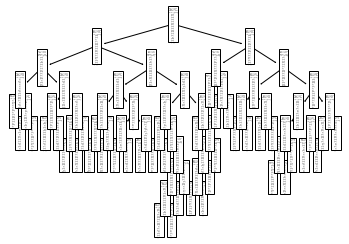

In [20]:
# printing the topology of the decision tree
tree.plot_tree(DTR_best)

## 3- Using Bayesian Random Forests to perform Multi-Variable Regression

### 3.1 - Bayesian Random Forests Hyperparameter Optimisation using GridSearchCV

In [21]:
parameters = {
    'max_depth': np.arange(1,21), # the depth of the tree will be between 1 and 20 branching rows
    'n_estimators':np.arange(1,21), # the number of trees in the forest will be between 1 and 20
    'max_features':["auto", "log2", "sqrt"],
    'min_samples_leaf': np.arange(2,21), # the minimum number of samples in each leaf will be between 2 and 30
    'bootstrap':[True, False]
}

In [22]:
gridCVRFR = GridSearchCV(RandomForestRegressor(), parameters, cv=6, n_jobs = -1)        # estimator = an instance of DecisionTreeClassifier.
gridCVRFR.fit(X_train, Y_train)
best_depth_rfr = gridCVRFR.best_params_['max_depth']
best_min_samples_leaf_rfr = gridCVRFR.best_params_['min_samples_leaf']
#best_max_leaf_nodes_rfr = gridCVRFR.best_params_['max_leaf_nodes']
best_max_features_rfr = gridCVRFR.best_params_['max_features']
best_bootstrap_rfr = gridCVRFR.best_params_['bootstrap']
best_n_estimators_rfr = gridCVRFR.best_params_['n_estimators']
print("Tree best depth : " + str(best_depth_rfr))
print("Tree best min_samples_leaf : " + str(best_min_samples_leaf_rfr))
#print("Tree best max_leaf_nodes : " + str(best_max_leaf_nodes_rfr))
print("Tree best max_features : " + str(best_max_features_rfr))
print("Tree best bootstrap : " + str(best_bootstrap_rfr))
print("Tree best n_estimators : " + str(best_n_estimators_rfr))


Tree best depth : 12
Tree best min_samples_leaf : 2
Tree best max_features : auto
Tree best bootstrap : True
Tree best n_estimators : 18


### 3.2 - Bayesian Random Forests Ensemble Regressor Testing and Evaluation

In [23]:
RFR_best = RandomForestRegressor(
    max_depth=best_depth_rfr,
    min_samples_leaf=best_min_samples_leaf_rfr,
    #max_leaf_nodes=best_max_leaf_nodes_rfr,
    n_estimators=best_n_estimators_rfr,
    bootstrap=best_bootstrap_rfr,
    max_features=best_max_features_rfr,
    random_state=1234,
    n_jobs=-1
)
RFR_best.fit(X_train, Y_train)
Y_pred = RFR_best.predict(X_test)
print( "Tree best RMSE : " + str(np.round(np.sqrt(metrics.mean_squared_error(Y_test,Y_pred, squared=True)),5)))

Tree best RMSE : 0.07905


In [24]:
# Comparing the predicted values with the real values
y_evaluation = RFR_best.predict(x_evaluating)
y_evaluation

array([[0.82840112, 0.24611941, 0.66666667, 0.        , 0.76763614,
        0.68904354, 0.89415871, 0.08669186, 0.84443162, 0.57830202,
        0.47800798, 0.66470776, 0.04806582, 0.05794762, 0.        ,
        0.90515046, 0.3520965 , 0.01257866]])

In [25]:
# denormalising the prediction
y_evaluation = y_scaler.inverse_transform(y_evaluation)
predicted = pd.DataFrame(y_evaluation, columns=Y.columns, index=["Predicted"])
real = pd.DataFrame(y_scaler.inverse_transform(Y_test.iloc[0:1]), columns=Y.columns, index=["Real"])
# Comparing the predicted values with the real values
pd.concat([predicted, real], axis=0).T

,Predicted,Real
vdsat,4.397153e-01,4.512000e-01
self_gain,5.003608e+00,5.459000e+00
region,2.000000e+00,2.000000e+00
ron,0.000000e+00,0.000000e+00
id,2.345128e-03,2.444000e-03
gmbs,1.903827e-04,1.922000e-04
gm,3.542657e-03,3.604000e-03
gds,7.210162e-04,6.602000e-04
ft,3.240929e+11,3.296000e+11
csb,9.125083e-16,9.313000e-16


# 4- Results Comparison

As it is possible to observe, the obtained RMSE for each of the models were:
- Multi-Layer Perceptron (MLP) Regressor: RMSE = 0.08229
- Bayesian Tree Regressor: RMSE = 0.12366
- Bayesian Random Forest (BRF) Regressor: RMSE = 0.07905

The MLPRegressor and the BRFRegressor are the models that present the smallest RMSE when compared to the Bayesian Tree Regressor, being the most accurate when performing multi-variable regression over the input LUT. However, the BRF Regressor presents a very important advantage over the MLP Regressor. The MLP Regressor presents trouble when dealing with normalized values that present themselves near the extremes of the MinMaxScaler domain. Furthermore, the MLP Regressor has a severe difficuly of correctly outputing the expected value of zero for entries that were previously missing values - a weakness that is not shown by the BRF Regressor, a regression model that also presents a better RMSE evaluation. To conclude, the chosen model to be used as an experimental model for the multi-variable regression of the LUTs that model the DC OP of the NMOS transistor is the Bayesian Random Forest Regressor, once it simultaneously presents a better fitting to the data (having a lower RMSE) and also presents the necessary risillience towards dealing with values that are near the extremes of each variable/column spatial domain.

# 5-Saving the models


In [27]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [28]:
import joblib
from sklearn.pipeline import make_pipeline

In [35]:
# create a pipeline model including the input scaler, the random forest regressor and the output scaler
pipeline = make_pipeline(
    MinMaxScaler(), 
    RandomForestRegressor(
        max_depth=best_depth_rfr,
        min_samples_leaf=best_min_samples_leaf_rfr,
        #max_leaf_nodes=best_max_leaf_nodes_rfr,
        n_estimators=best_n_estimators_rfr,
        bootstrap=best_bootstrap_rfr,
        max_features=best_max_features_rfr,
        random_state=1234,
        n_jobs=-1
    )
) # creating a pipeline :Input ->  x_scaler -> RFR_best -> y_scaler -> Output

In [36]:
pipeline.fit(X_train, Y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=12, min_samples_leaf=2,
                                       n_estimators=18, n_jobs=-1,
                                       random_state=1234))])

In [37]:
# save the pipeline and the isolated scalers + random forest regression model
import os
files = {
    "xscaler.mod": x_scaler,
    "yscaler.mod": y_scaler,
    "rfr.mod": RFR_best,
    "pipeline.mod": pipeline
}
for filename, obj in files.items():
    path = os.path.join("/Users/dasdias/Documents/PhD-NOVA/Circuits/ResidueAmplifier_Gain8_28nmTSMC/goverpy/resources/model/models/ncell", filename)
    joblib.dump(obj, path)

In [47]:
# loading the models from the disk and checking if everything is fine
pipeline_model = joblib.load("/Users/dasdias/Documents/PhD-NOVA/Circuits/ResidueAmplifier_Gain8_28nmTSMC/goverpy/resources/model/models/ncell/pipeline.mod")
y_pred_load = y_scaler.inverse_transform(pipeline_model.predict(nmos_df[x_columns].iloc[0:1]))
y_real = nmos_df[Y.columns].iloc[0:1].values
print(y_real)
pd.concat([pd.DataFrame(y_pred_load, columns=Y.columns, index=["Predicted"]), pd.DataFrame(y_real, columns=Y.columns, index=["Real"])], axis=0).T

[[1.037e-01 8.939e+00 0.000e+00 1.350e+08 6.941e-09 9.663e-09 1.774e-07
  1.985e-08 3.573e+07 7.171e-16 3.659e-16 5.794e-16 3.246e-16 9.960e-17
  2.300e-06 0.000e+00 0.000e+00 0.000e+00]]


,Predicted,Real
vdsat,1.030774e-01,1.037000e-01
self_gain,1.111183e+01,8.939000e+00
region,1.796296e+00,0.000000e+00
ron,2.383293e+07,1.350000e+08
id,3.837057e-08,6.941000e-09
gmbs,7.038656e-08,9.663000e-09
gm,1.054392e-06,1.774000e-07
gds,1.300413e-07,1.985000e-08
ft,2.000368e+08,3.573000e+07
csb,7.485428e-16,7.171000e-16


# 6-Future Work

- Some aspects can be pinned down as future work in this enterprise, and to obtain a reliable system, they absolutely must be tackled.
The first aspect is the precision of the MinMaxScaler - a better precision must be acquired in order to obtain an even better RMSE evaluation, especially regarding the values of Ft, Ron and self_gain. These values cover a wide range of values, and when scaled, they lack the necessary precision one would hope.
- Another important endeavour is to find a scheme to robustly preserve the lost information during the removal of the NaN and infinity numbers from the database. The missing values must be substituted by a number that makes sense in the point of view of an electrical simulation model.
- The last aspect to be covered is to correctly scale the capacitances that are outputed when scaling the width of the transistor's channel. The increase of the width must always be accompanied by an increase of the number of fingers used in the layout mask of the device, and this information must be included into the software for more complete CMOS sizing tool.